In [19]:
# Load library for DESeq2 - differential expression analysis
library(DESeq2)

# Load library for RColorBrewer
library(RColorBrewer)



# Load library for tidyverse
library(tidyverse)
# Load library for pheatmap
library(pheatmap)

Warning message:
"package 'pheatmap' was built under R version 4.3.1"


In [2]:
#Let's explore the content of raw count matrix
smoc2_rawcounts<-read.csv('fibrosis_smoc2_rawcounts.csv')

# Explore the first six observations of smoc2_rawcounts
head(smoc2_rawcounts)


,X,smoc2_fibrosis1,smoc2_fibrosis4,smoc2_normal1,smoc2_normal3,smoc2_fibrosis3,smoc2_normal4,smoc2_fibrosis2
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000102693,0,0,0,0,0,0,0
2,ENSMUSG00000064842,0,0,0,0,0,0,0
3,ENSMUSG00000051951,72,30,0,3,36,1,51
4,ENSMUSG00000102851,0,0,0,0,0,0,0
5,ENSMUSG00000103377,0,0,1,0,0,0,0
6,ENSMUSG00000104017,0,0,0,0,0,0,0


In [3]:
# Explore the structure of smoc2_rawcounts
str(smoc2_rawcounts)

'data.frame':	47729 obs. of  8 variables:
 $ X              : chr  "ENSMUSG00000102693" "ENSMUSG00000064842" "ENSMUSG00000051951" "ENSMUSG00000102851" ...
 $ smoc2_fibrosis1: int  0 0 72 0 0 0 0 0 0 1 ...
 $ smoc2_fibrosis4: int  0 0 30 0 0 0 0 0 0 1 ...
 $ smoc2_normal1  : int  0 0 0 0 1 0 0 0 0 1 ...
 $ smoc2_normal3  : int  0 0 3 0 0 0 0 0 0 0 ...
 $ smoc2_fibrosis3: int  0 0 36 0 0 0 0 0 0 1 ...
 $ smoc2_normal4  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ smoc2_fibrosis2: int  0 0 51 0 0 0 0 0 0 1 ...


To employ DESeq2 model first we need to make metadata dataframe

In [4]:
# Create genotype vector
genotype <- c('smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe')

# Create condition vector
condition <- c("fibrosis","fibrosis","fibrosis","fibrosis","normal","normal","normal")

# Create data frame
smoc2_metadata <- data.frame(genotype,condition)

# Assign the row names of the data frame
rownames(smoc2_metadata) <- c('smoc2_fibrosis1','smoc2_fibrosis2','smoc2_fibrosis3','smoc2_fibrosis4','smoc2_normal1','smoc2_normal3','smoc2_normal4')

In [5]:
smoc2_metadata

,genotype,condition
,<chr>,<chr>
smoc2_fibrosis1,smoc2_oe,fibrosis
smoc2_fibrosis2,smoc2_oe,fibrosis
smoc2_fibrosis3,smoc2_oe,fibrosis
smoc2_fibrosis4,smoc2_oe,fibrosis
smoc2_normal1,smoc2_oe,normal
smoc2_normal3,smoc2_oe,normal
smoc2_normal4,smoc2_oe,normal


To assemble statistical model we need to create DESeq2 object. The function - DESeqDataSetFromMatrix has three arguments: raw count matrix, metadata dataframe and design of the formula. In our research DE analysis based on condition: fibrosis/no fibrosis. The formula must contain exact name of the column from metadata

In [6]:
# Use the match() function to reorder the columns of the raw counts
reorder_idx <- match(rownames(smoc2_metadata),colnames(smoc2_rawcounts))
reorder_idx

[1] 2 8 6 3 4 5 7

In [7]:
# Reorder the columns of the count data
reordered_smoc2_rawcounts <- smoc2_rawcounts[,reorder_idx]
head(reordered_smoc2_rawcounts)

,smoc2_fibrosis1,smoc2_fibrosis2,smoc2_fibrosis3,smoc2_fibrosis4,smoc2_normal1,smoc2_normal3,smoc2_normal4
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,72,51,36,30,0,3,1
4,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0


In [8]:
# Create a DESeq2 object
dds_smoc2 <- DESeqDataSetFromMatrix(countData = reordered_smoc2_rawcounts,
                              colData =  smoc2_metadata,
                              design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


* Count normalization there are a number of factors other than RNA expression which can influence the number of reads aligning to each gene. A total number of reads can be different from sample to sample. Another issue that longer genes generate more fragments. Since DE analysis compares the same genes between conditions, we do not need to normalize for gene length. However, if you compare expression levels of different genes you will need to account for lengths of the genes.
* Library composition effect When adjusting to library size, the composition of the library is also important. A few highly expressed genes can skew many normalization methods that are not resistant to this outliers. DESeq2 is employed median of ratios method of normalization.

In [9]:
# Determine the size factors to use for normalization
dds_smoc2 <- estimateSizeFactors(dds_smoc2)

In [10]:
# Extract the normalized counts
smoc2_normalized_counts <- counts(dds_smoc2, normalized=TRUE)

In [12]:
head(smoc2_normalized_counts)

smoc2_fibrosis1,smoc2_fibrosis2,smoc2_fibrosis3,smoc2_fibrosis4,smoc2_normal1,smoc2_normal3,smoc2_normal4
0.00000,0.00000,0.0000,0.00000,0.000000,0.000000,0.000000
0.00000,0.00000,0.0000,0.00000,0.000000,0.000000,0.000000
50.27992,45.57786,28.8461,27.70902,0.000000,3.754818,1.178908
0.00000,0.00000,0.0000,0.00000,0.000000,0.000000,0.000000
0.00000,0.00000,0.0000,0.00000,1.407166,0.000000,0.000000
0.00000,0.00000,0.0000,0.00000,0.000000,0.000000,0.000000


Unsupervised clustering analysis:

- hierarchical clustering heat maps
- principal component analysis

log transformation (variance stabilizing transformation - moderates a variance across the mean)

if our replicates are not clustered as expected, we could plot a heatmap with all the metadata and see whether any other factor corresponds to separation. If you see outlier in clustering, you want to check it in PCA too. If you see an outlier in both methods you could investigate this sample more and decide whether to remove it from the analysis.

In [13]:
# Transform the normalized counts 
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)
vsd_smoc2

class: DESeqTransform 
dim: 6 7 
metadata(1): version
assays(1): ''
rownames: NULL
rowData names(4): baseMean baseVar allZero dispFit
colnames(7): smoc2_fibrosis1 smoc2_fibrosis2 ... smoc2_normal3
  smoc2_normal4
colData names(3): genotype condition sizeFactor

In [14]:
vsd_smoc2

class: DESeqTransform 
dim: 47729 7 
metadata(1): version
assays(1): ''
rownames: NULL
rowData names(4): baseMean baseVar allZero dispFit
colnames(7): smoc2_fibrosis1 smoc2_fibrosis2 ... smoc2_normal3
  smoc2_normal4
colData names(3): genotype condition sizeFactor

In [15]:
# Extract the matrix of transformed counts
vsd_mat_smoc2 <- assay(vsd_smoc2)
vsd_mat_smoc2

smoc2_fibrosis1,smoc2_fibrosis2,smoc2_fibrosis3,smoc2_fibrosis4,smoc2_normal1,smoc2_normal3,smoc2_normal4
3.641580,3.641580,3.641580,3.641580,3.641580,3.641580,3.641580
3.641580,3.641580,3.641580,3.641580,3.641580,3.641580,3.641580
6.191998,6.092895,5.664960,5.630072,3.641580,4.423310,4.083260
3.641580,3.641580,3.641580,3.641580,3.641580,3.641580,3.641580
3.641580,3.641580,3.641580,3.641580,4.123767,3.641580,3.641580
3.641580,3.641580,3.641580,3.641580,3.641580,3.641580,3.641580
3.641580,3.641580,3.641580,3.641580,3.641580,3.641580,3.641580
3.641580,3.641580,3.641580,3.641580,3.641580,3.641580,3.641580
3.641580,3.641580,3.641580,3.641580,3.641580,3.641580,3.641580
3.982055,4.026497,4.006166,4.032855,4.123767,3.641580,3.641580


In [16]:
# Compute the correlation values between samples
vsd_cor_smoc2 <- cor(vsd_mat_smoc2) 


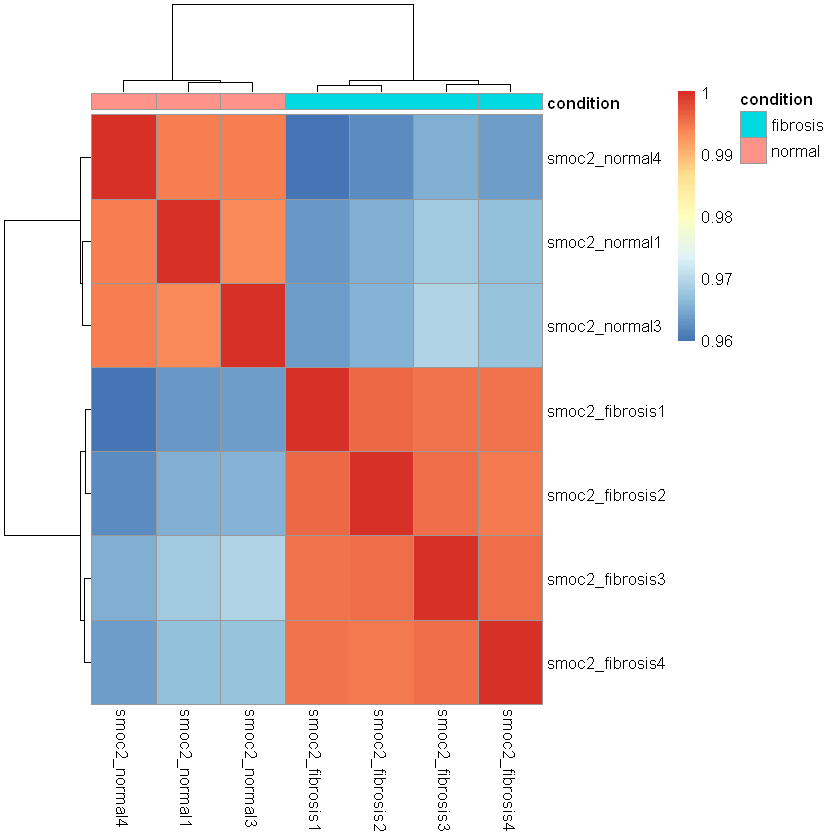

In [20]:
# Plot the heatmap
pheatmap(vsd_cor_smoc2, annotation = select(smoc2_metadata, condition))

Principal component analysis

We can make clusters by making principal components (PC1 and PC2) - vectors which represent the biggest change in the number of reads of genes across the samples

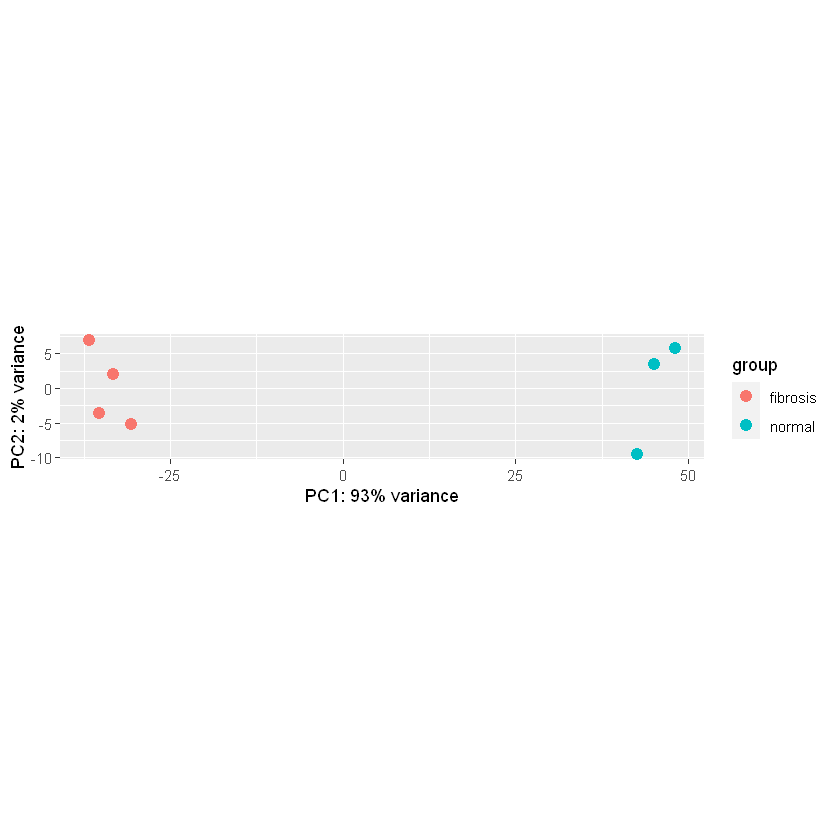

In [21]:
# Transform the normalized counts 
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)

# Plot the PCA of PC1 and PC2
plotPCA(vsd_smoc2, intgroup='condition')

DE analysis workflow:

1. fitting the raw counts to each gene to DEseq2 negative binomial model and testing for differential expression
2. shrinking log2 fold changes
3. extracting and visualizing the result

1.Modelling raw counts for each gene:

1.1 estimate size factors

1.2 estimate variation in expression across replicates for each gene

1.3 fit to negative binomial model

Variation and Dispersion

How well our data fit the model?

To model the counts requires the mean and variation in the data

To explore the variation of the data we will explore the variance in gene expression relative to the mean. Variance is a square of standart deviation, representing how far away the individual samples are from the mean. For RNAseq data the variance is generally expected to increase with the gene's mean expression. A measure of the variance for a given mean is described by the metric called dispersion:

Variance=mean+dispersion x mean^2

Plot of dispersion relative to the mean for each gene can be useful to check if our data fit to DEseq model. We expect dispersion values to decrease with increasing mean. With only a few replicates for RNAseq data, gene-wise estimates of dispersion are often inaccurate. DEseq uses information across all genes to determine the most likely estimates for a given mean expression value.

If dispersions don't decrease with increasing mean this problem can be often explaned by contamination and sample outliers.

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



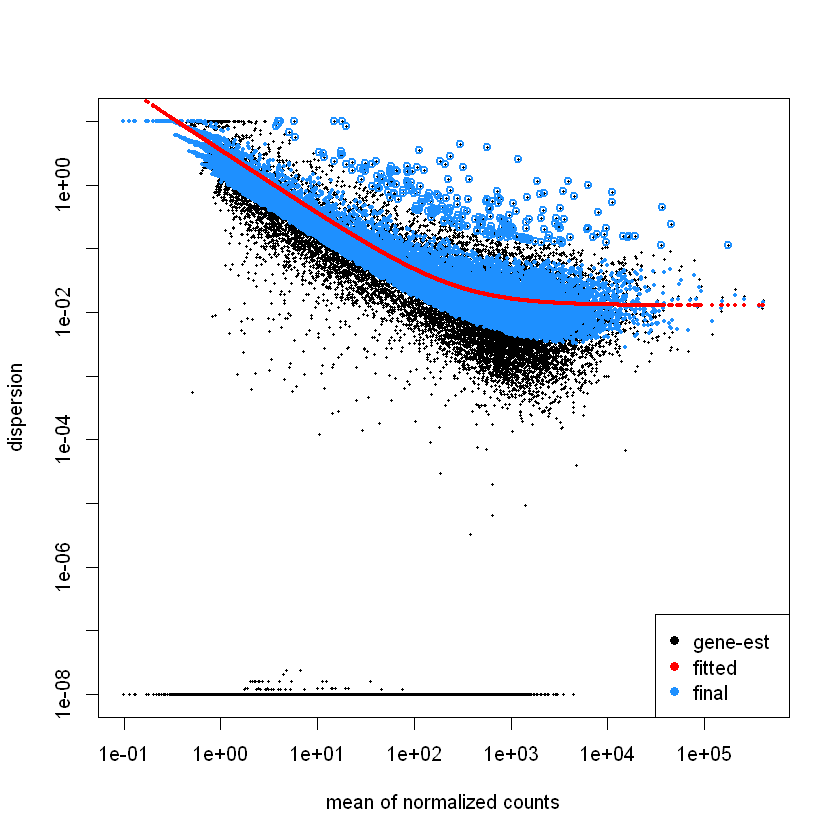

In [22]:
# Plot dispersions
dds_smoc2_<-DESeq(dds_smoc2)
plotDispEsts(dds_smoc2_)

In [25]:
head(dds_smoc2_)

class: DESeqDataSet 
dim: 6 7 
metadata(1): version
assays(4): counts mu H cooks
rownames: NULL
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(7): smoc2_fibrosis1 smoc2_fibrosis2 ... smoc2_normal3
  smoc2_normal4
colData names(3): genotype condition sizeFactor

In [23]:
# Extract the results of the differential expression analysis
smoc2_res <- results(dds_smoc2_, 
                contrast = c('condition','fibrosis','normal'), 
                alpha = 0.05)

In [24]:
head(smoc2_res)

log2 fold change (MLE): condition fibrosis vs normal 
Wald test p-value: condition fibrosis vs normal 
DataFrame with 6 rows and 6 columns
   baseMean log2FoldChange     lfcSE      stat      pvalue        padj
  <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
1  0.000000             NA        NA        NA          NA          NA
2  0.000000             NA        NA        NA          NA          NA
3 22.478090        4.49814  0.829291  5.424085 5.82520e-08 2.54201e-07
4  0.000000             NA        NA        NA          NA          NA
5  0.201024       -1.59170  3.816946 -0.417009 6.76672e-01          NA
6  0.000000             NA        NA        NA          NA          NA

In [27]:
# Shrink the log2 fold change estimates to be more accurate
smoc2_res <- lfcShrink(dds_smoc2_, 
                    contrast =  c('condition', 'fibrosis', 'normal'),
                    res = smoc2_res, type="normal")

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [28]:
# Extract results
smoc2_res <- results(dds_smoc2_, 
                contrast = c("condition", "fibrosis", "normal"), 
                alpha = 0.05, 
                lfcThreshold = 0.32)

In [29]:
# Shrink the log2 fold changes
smoc2_res <- lfcShrink(dds_smoc2_, 
                    contrast = c("condition", "fibrosis", "normal"), 
                    res = smoc2_res,type="normal")

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [30]:
# Get an overview of the results                    
summary(smoc2_res)

# Save results as a data frame
smoc2_res_all <- data.frame(smoc2_res)

# Subset the results to only return the significant genes with p-adjusted values less than 0.05
smoc2_res_sig <- subset(smoc2_res_all, padj < 0.05)


out of 29556 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3716, 13%
LFC < 0 (down)     : 3322, 11%
outliers [1]       : 15, 0.051%
low counts [2]     : 7207, 24%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [31]:
dim(smoc2_res_all)

[1] 47729     6

In [32]:
dim(smoc2_res_sig)

[1] 7038    6

Visualisation of results

1. Expression heatmap
2. Volcano plot
3. MA plot

To explore the results, visualizations can be helpful to see a global view of the data, as well as, characteristics of the significant genes. Usually, we expect to see significant genes identified across the range of mean values, which we can plot using the MA plot. If we only see significant genes with high mean values, then it could indicate an issue with our data. The volcano plot helps us to get an idea of the range of fold changes needed to identify significance in our data.

Let's explore our results using MA plots and volcano plots.

Warning message:
"Removed 25395 rows containing missing values (`geom_point()`)."


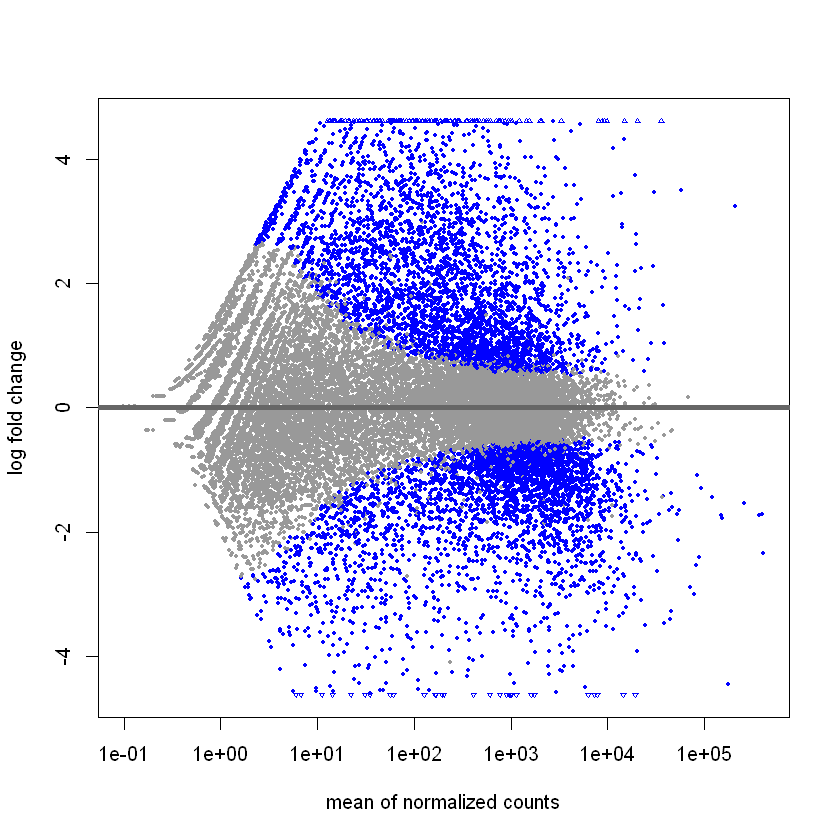

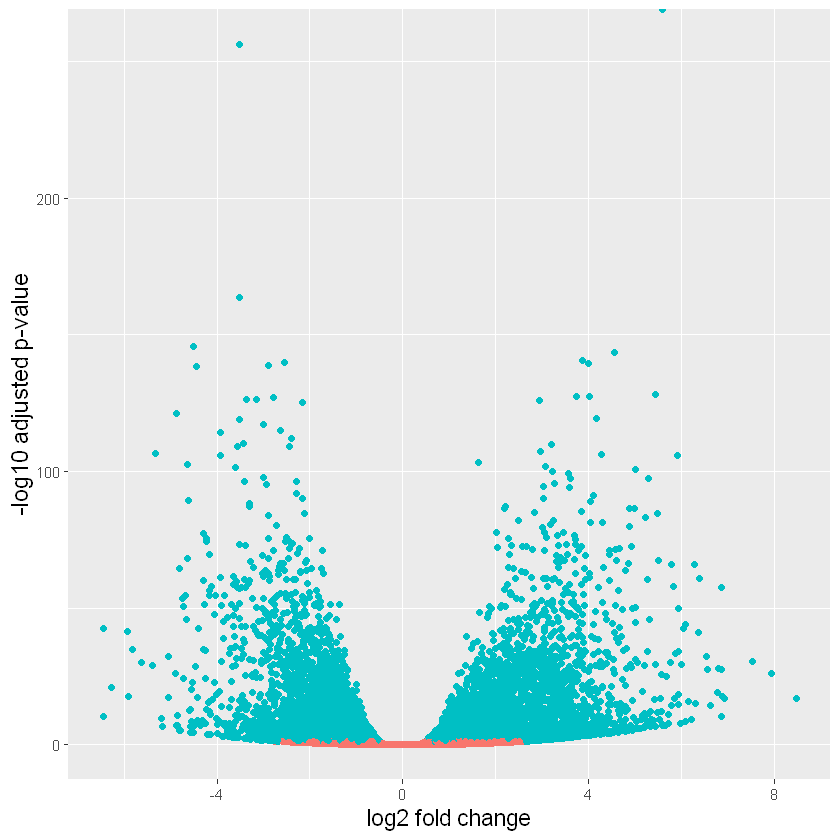

In [33]:
# Create MA plot
plotMA(smoc2_res)

# Generate logical column 
smoc2_res_all <- data.frame(smoc2_res) %>% mutate(threshold = padj < 0.05)
              
# Create the volcano plot
ggplot(smoc2_res_all) + 
        geom_point(aes(x = log2FoldChange, y = -log10(padj), color = threshold)) + 
        xlab("log2 fold change") + 
        ylab("-log10 adjusted p-value") + 
        theme(legend.position = "none", 
              plot.title = element_text(size = rel(1.5), hjust = 0.5), 
              axis.title = element_text(size = rel(1.25)))

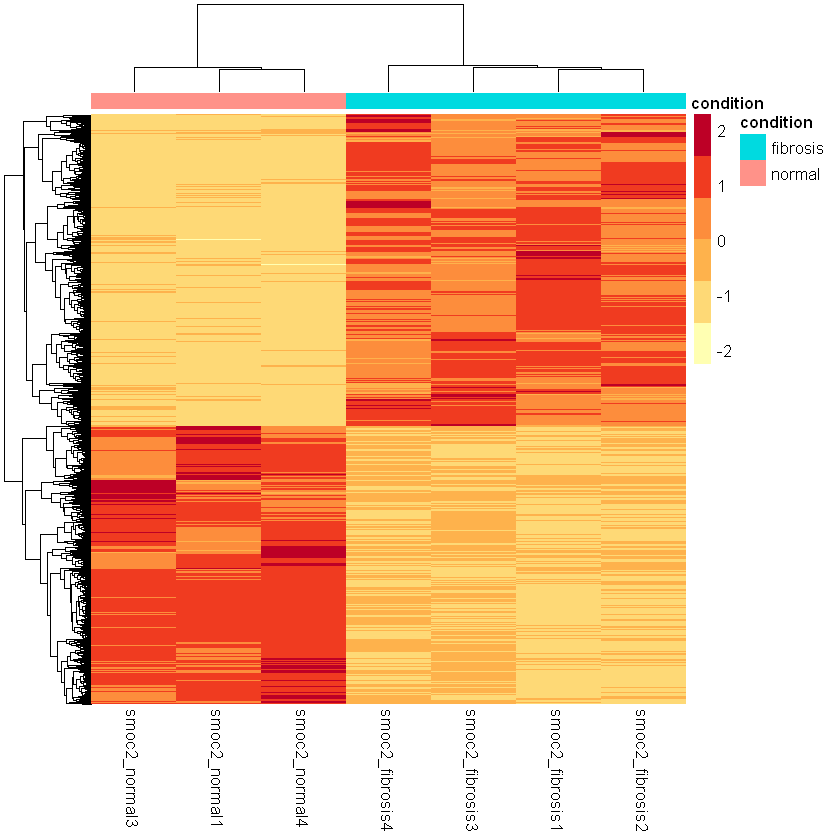

In [34]:
#Transform normalized counts to dataframe
smoc2_normalized_counts<-data.frame(smoc2_normalized_counts)

# Subset normalized counts to significant genes
sig_norm_counts_smoc2 <- smoc2_normalized_counts[rownames(smoc2_res_sig), ]

# Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")

# Plot heatmap
pheatmap(sig_norm_counts_smoc2, 
         color = heat_colors, 
         cluster_rows = T, 
         show_rownames = F,
         annotation = select(smoc2_metadata, condition), 
         scale = 'row')